In [194]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt

In [195]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

In [196]:
N_STEPS = 7
LOOKUP_STEPS = [1]
STOCK = 'KAHOT.OL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = ((dt.date.today() - dt.timedelta(days=1)) - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [197]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [198]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

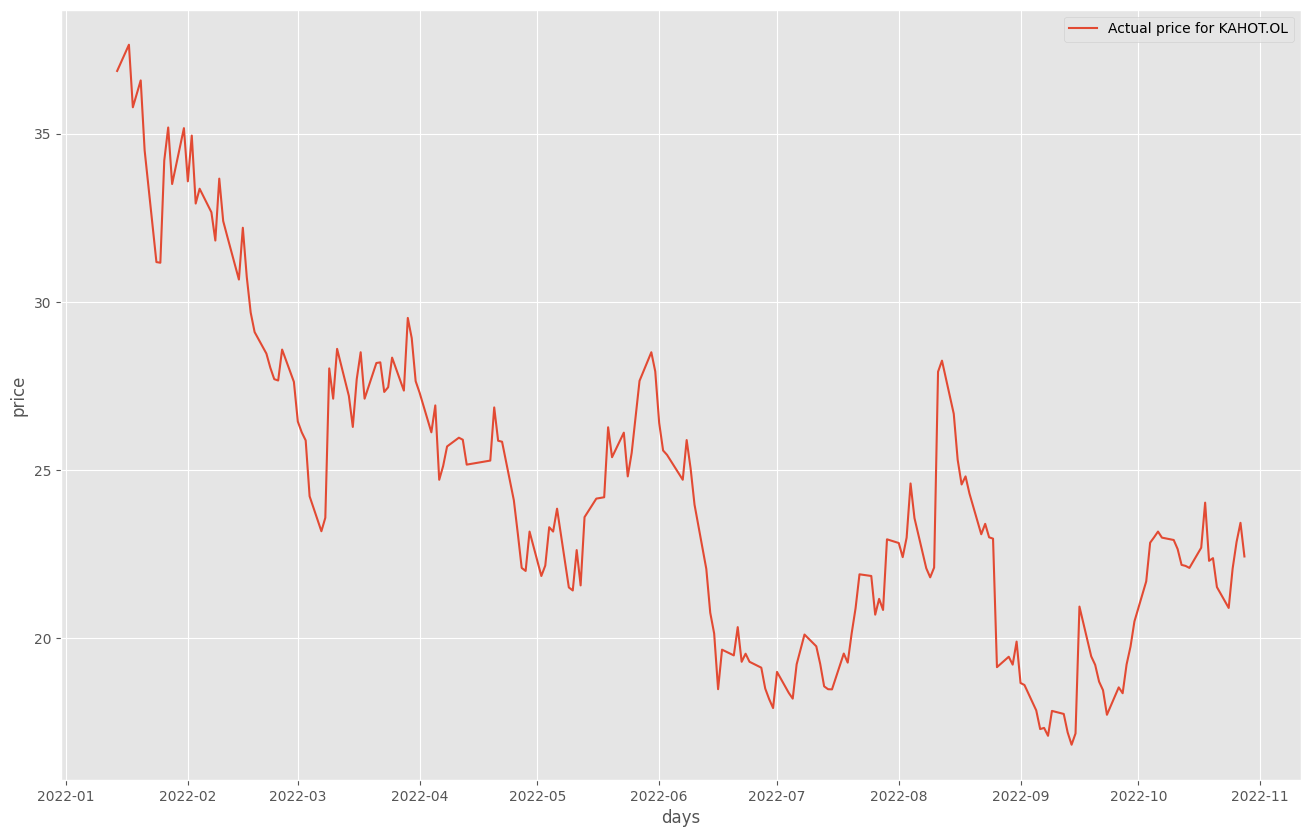

In [199]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [200]:

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [201]:

def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(attention(return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(20))
  model.add(Dense(1))

  # model2 = Sequential()
  # model2.add(Embedding(n_unique_words, 128, input_length=maxlen))
  # model2.add(Bidirectional(LSTM(64, return_sequences=True)))
  # model2.add(attention(return_sequences=True)) # receive 3D and output 3D
  # model2.add(Dropout(0.5))
  # model2.add(Dense(1, activation='sigmoid'))
  # model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # model2.summary()

  BATCH_SIZE = 8
  EPOCHS = 100

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model.summary()

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [202]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [203]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 7, 60)             14880     
                                                                 
 attention_4 (attention)     (None, 7, 60)             67        
                                                                 
 dropout_30 (Dropout)        (None, 7, 60)             0         
                                                                 
 lstm_36 (LSTM)              (None, 120)               86880     
                                                                 
 dropout_31 (Dropout)        (None, 120)               0         
                                                                 
 dense_26 (Dense)            (None, 20)                2420      
                                                                 
 dense_27 (Dense)            (None, 1)               

In [ ]:
predictions

[24.7]